In [15]:
# Cell 1: Imports & Device Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import os

# SETUP DEVICE (This ensures it runs on your GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# If using GPU, enable benchmark mode for faster training
if device.type == 'cuda':
    torch.backends.cudnn.benchmark

Using device: cuda


In [9]:
# 2. Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 0.001
EPOCHS = 10
IMG_SIZE = (224, 224)
DATA_DIR = r"F:\WIDS-5.0\data\plantvillage dataset\color" # UPDATE THIS PATH

In [10]:
# Cell 2: Data Loading & Transforms
# PyTorch uses "Transforms" for preprocessing
train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(), # Converts 0-255 to 0.0-1.0 automatically
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # Normalize to [-1, 1]
])

val_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load entire dataset
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)

# Split into Train (80%) and Val (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply validation transforms specifically to val_dataset (Optional override)
val_dataset.dataset.transform = val_transform 

# Create Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Classes: {full_dataset.classes}")

Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___

In [11]:
# Cell 3: Define Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 2
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Block 3
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # Classifier
        self.flatten = nn.Flatten()
        # 224 / 2 / 2 / 2 = 28. So 128 channels * 28 * 28 spatial size
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu4(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=len(full_dataset.classes)).to(device) # Move to GPU
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=38, bias=True)
)


In [12]:
# Cell 4: Training Loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_acc_history = []
val_acc_history = []

for epoch in range(EPOCHS):
    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Move data to GPU
        
        optimizer.zero_grad() # Clear gradients
        outputs = model(inputs) # Forward pass
        loss = criterion(outputs, labels) # Calculate loss
        loss.backward() # Backprop
        optimizer.step() # Update weights
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_acc = 100 * correct / total
    train_acc_history.append(epoch_acc)
    
    # --- VALIDATE ---
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad(): # No need to track gradients for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_acc = 100 * val_correct / val_total
    val_acc_history.append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {running_loss/len(train_loader):.4f} | Train Acc: {epoch_acc:.2f}% | Val Acc: {val_acc:.2f}%")

Epoch 1/10 | Loss: 1.4673 | Train Acc: 58.89% | Val Acc: 81.47%
Epoch 2/10 | Loss: 0.7065 | Train Acc: 78.21% | Val Acc: 90.33%
Epoch 3/10 | Loss: 0.5140 | Train Acc: 83.58% | Val Acc: 91.68%
Epoch 4/10 | Loss: 0.4005 | Train Acc: 87.04% | Val Acc: 93.52%
Epoch 5/10 | Loss: 0.3312 | Train Acc: 89.29% | Val Acc: 92.51%
Epoch 6/10 | Loss: 0.2756 | Train Acc: 90.76% | Val Acc: 94.09%
Epoch 7/10 | Loss: 0.2272 | Train Acc: 92.35% | Val Acc: 94.85%
Epoch 8/10 | Loss: 0.2074 | Train Acc: 92.99% | Val Acc: 95.31%
Epoch 9/10 | Loss: 0.1708 | Train Acc: 94.18% | Val Acc: 95.24%
Epoch 10/10 | Loss: 0.1655 | Train Acc: 94.46% | Val Acc: 95.48%


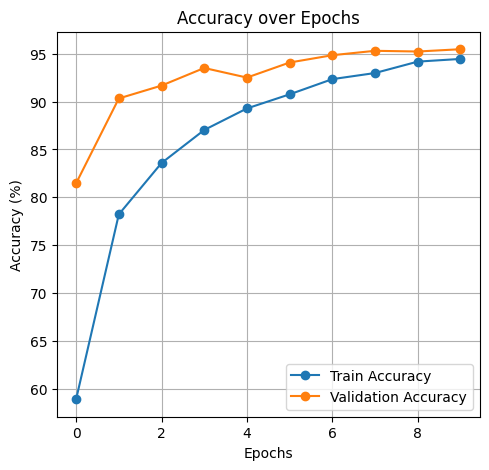

In [13]:
# --- PLOT ACCURACY & LOSS ---
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Accuracy', marker='o')
plt.plot(val_acc_history, label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot Loss (We need to capture loss history first - see note below)
# Ideally, you should append 'running_loss/len(train_loader)' to a list inside your loop
# Assuming you have a list called 'train_loss_history':
# plt.subplot(1, 2, 2)
# plt.plot(train_loss_history, label='Train Loss', color='red', marker='o')
# plt.title('Loss over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)

plt.show()

Running inference on 100 random validation images...

--- Test Results ---
Accuracy: 97.00% (97/100 correct)

--- DETAILED ERROR LOG (3 mistakes) ---
Mistake 1: True Class 'Grape___healthy' ---> Wrongly Predicted as 'Soybean___healthy'
Mistake 2: True Class 'Tomato___Late_blight' ---> Wrongly Predicted as 'Apple___healthy'
Mistake 3: True Class 'Tomato___healthy' ---> Wrongly Predicted as 'Tomato___Spider_mites Two-spotted_spider_mite'


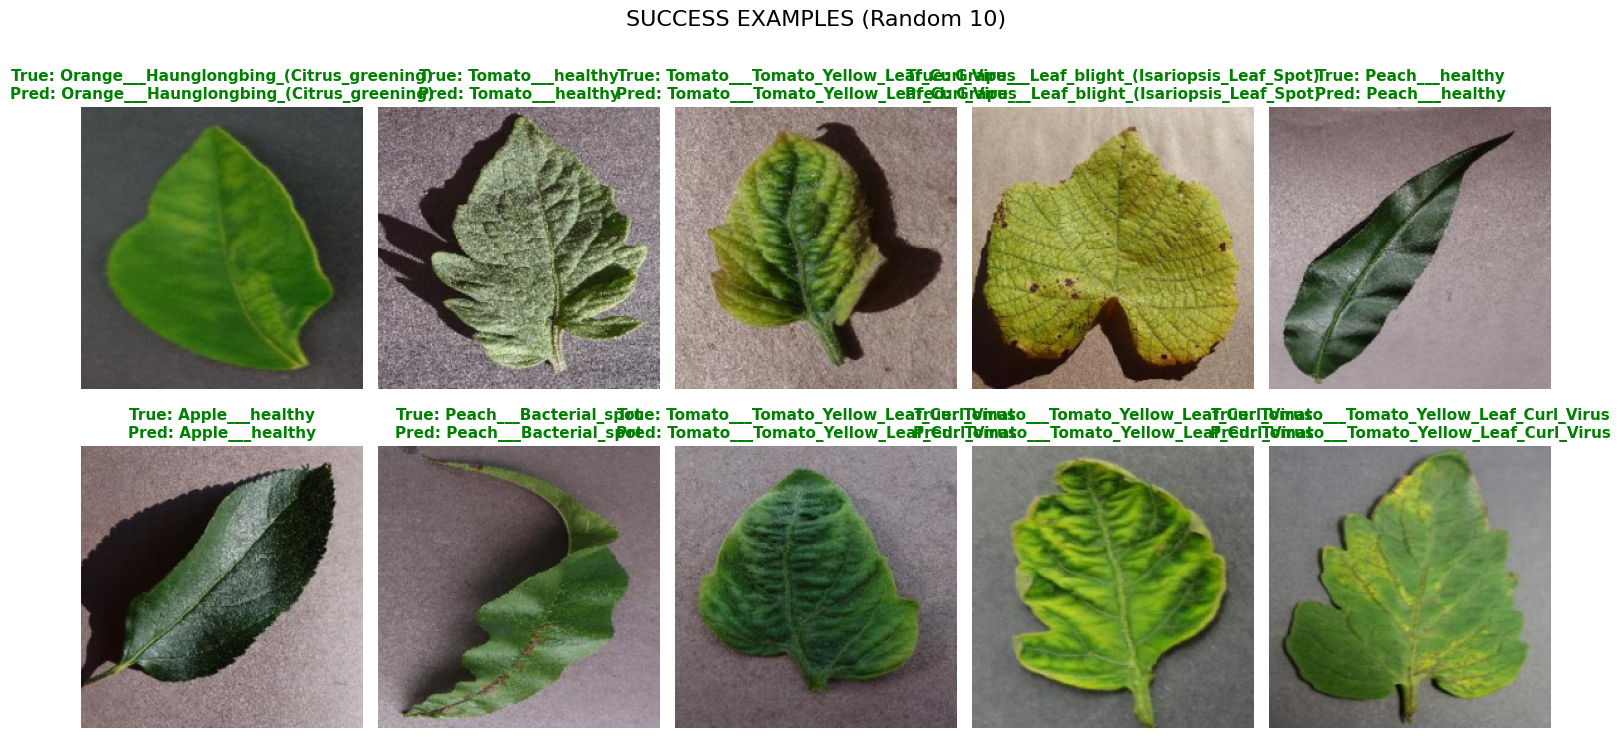

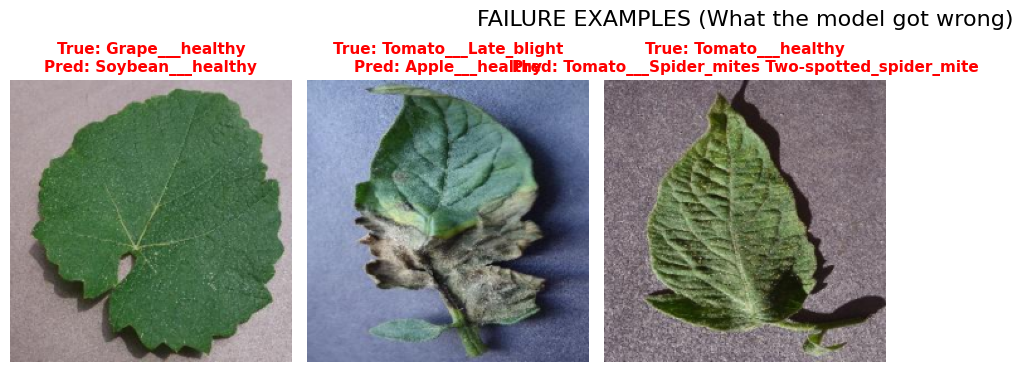

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

class_names = full_dataset.classes

# Helper: Un-normalize image for display
def unnormalize_and_convert(tensor_img):
    img = tensor_img.cpu().clone()
    img = img * 0.5 + 0.5     # Un-normalize (reverse the -1 to 1)
    img = img.permute(1, 2, 0).numpy()
    return np.clip(img, 0, 1)

# ==========================================
# 2. RUN RANDOM SAMPLING (100 Images)
# ==========================================
total_val_images = len(val_dataset)
indices = random.sample(range(total_val_images), 100)

successes = []
failures = []

print(f"Running inference on 100 random validation images...")

with torch.no_grad():
    for idx in indices:
        image, true_label = val_dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)
        
        # PREDICT
        outputs = model(input_tensor)
        _, pred_label = torch.max(outputs, 1)
        pred_label = pred_label.item()
        
        item = {
            'img': unnormalize_and_convert(image), 
            'true_idx': true_label,
            'pred_idx': pred_label,
            'true_name': class_names[true_label],
            'pred_name': class_names[pred_label]
        }
        
        if pred_label == true_label:
            successes.append(item)
        else:
            failures.append(item)

# ==========================================
# 3. TEXT SUMMARY OF ERRORS
# ==========================================
acc = len(successes) / 100 * 100
print(f"\n--- Test Results ---")
print(f"Accuracy: {acc:.2f}% ({len(successes)}/100 correct)")

if len(failures) > 0:
    print(f"\n--- DETAILED ERROR LOG ({len(failures)} mistakes) ---")
    # Print the specific wrong predictions for the first 5 failures
    for i, f in enumerate(failures):
        print(f"Mistake {i+1}: True Class '{f['true_name']}' ---> Wrongly Predicted as '{f['pred_name']}'")
        if i >= 4: # Limit text output to 5 lines so it doesn't spam
            print(f"... and {len(failures)-5} more.")
            break
else:
    print("\nNo failures! Perfect score on this batch.")

# ==========================================
# 4. VISUALIZE OUTPUT
# ==========================================
def plot_grid(items, title, max_items=None):
    if not items: return
    
    display_list = items[:max_items] if max_items else items
    count = len(display_list)
    cols = 5
    rows = (count // cols) + (1 if count % cols > 0 else 0)
    
    plt.figure(figsize=(15, 3.8 * rows))
    plt.suptitle(title, fontsize=16, y=1.01)
    
    for i, data in enumerate(display_list):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(data['img'])
        
        # COLOR LOGIC: Green if correct, Red if wrong
        is_correct = data['true_idx'] == data['pred_idx']
        color = 'green' if is_correct else 'red'
        
        # THE TITLE SHOWS THE WRONG PREDICTION
        label_text = f"True: {data['true_name']}\nPred: {data['pred_name']}"
        
        plt.title(label_text, color=color, fontweight='bold', fontsize=11)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show 10 Successes
plot_grid(successes, "SUCCESS EXAMPLES (Random 10)", max_items=10)

# Show ALL Failures
if failures:
    plot_grid(failures, "FAILURE EXAMPLES (What the model got wrong)", max_items=None)

In [24]:
# 1. Create the folder if it doesn't exist
folder_name = "models"
os.makedirs(folder_name, exist_ok=True)

# 2. Define the full path
save_path = os.path.join(folder_name, "my_model.pth")

# 3. Save the model weights
torch.save(model.state_dict(), save_path)

print(f"Model saved successfully at: {save_path}")

Model saved successfully at: models\my_model.pth
